# Prototype hybrid matrix factorization model for drug reccomendations using PyTorch

## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader


from sklearn import metrics

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset, evaluate_predictions

## Load KINOMEscan preprocessed dataset with intersection of proteins screened for drugs

In [3]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)

Kinases Dataset <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset. 
- Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
mutations in 18 genes. Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
- Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
- Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered 


## Data preprocessing

#### Establish response data for samples (drug-cell line pairs)

In [4]:
response_df = full_dataset.response_data.copy()
print(response_df.shape, response_df.COSMIC_ID.nunique())
response_df.head(3)

(55936, 3) 987


,DRUG_ID,COSMIC_ID,AUC
2748,29,683665,0.945160
2749,29,684055,0.926046
2750,29,684057,0.934873


#### Establish cell line features data

In [5]:
cell_line_data_df = full_dataset.full_cell_lines_data.copy()
print(cell_line_data_df.shape)
cell_line_data_df.head(3)

(922, 225)


,cell_line_id,PRKX_exp,TIE1_exp,BMPR2_exp,PKMYT1_exp,ABL2_exp,PLK1_exp,ACVR1_exp,MAP3K4_mut,SRPK1_exp,...,Tissue_lung_SCLC,Tissue_lymphoma,Tissue_myeloma,Tissue_nervous_system,Tissue_neuroblastoma,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system
cell_line_id,,,,,,,,,,,,,,,,,,,,,
906826,906826,4.787607,3.056350,6.395463,5.550737,5.492917,3.853142,4.384087,0,7.410108,...,0,0,0,0,0,0,0,0,0,0
687983,687983,5.001763,3.125097,6.634672,5.399054,5.113815,4.218736,4.786061,0,7.776150,...,1,0,0,0,0,0,0,0,0,0
910927,910927,5.459631,2.989998,7.945827,5.541005,4.519127,3.694307,4.414635,0,7.079021,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
print(len(missing_cell_lines))

66


In [7]:
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_df.index = cell_line_data_df.cell_line_id
cell_line_data_df = cell_line_data_df.drop("cell_line_id", axis=1)

In [8]:
# Extract response only for cell lines for which features are present
print(response_df.shape)
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]
print(response_df.shape)

(55936, 3)
(52730, 3)


#### Establish drug features data

In [9]:
drug_data_df = full_dataset.drugs_data.copy()
print(drug_data_df.shape)
# Convert drug index from LINCS name to GDSC drug ID
drug_data_df.index = drug_data_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)
drug_data_df.head(3)

(74, 294)


Protein,MAPKAPK2,MARK1,CAMKK2,MARK2,TGFBR1,ERK5,EPHA7,MK01,RAF1,TNNI3K,...,KGP1,ZAP70,ERK3,BLK,MYLK2,KPCD3,FGFR3,ACVR1,GSK3A,KPCD
Small Molecule,,,,,,,,,,,,,,,,,,,,,
1242,100.0,83.0,88.0,96.0,57.0,100.0,92.0,64.0,100.0,77.0,...,99.0,86.0,98.0,57.0,80.0,12.0,95.0,1.9,100.0,100.0
86,100.0,100.0,2.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.7,100.0,100.0,100.0,100.0,1.6,100.0,100.0,1.0,0.9
29,100.0,100.0,28.0,92.0,100.0,100.0,84.0,100.0,2.3,15.0,...,100.0,100.0,100.0,1.0,100.0,88.0,100.0,100.0,100.0,89.0


In [10]:
# Search for drugs present in response data, but missing the drug features
missing_drugs = []
for drug_id in response_df.DRUG_ID.unique():
    if drug_id not in drug_data_df.index:
        print(drug_id)
        missing_drugs.append(drug_id)
print(len(missing_drugs))

0


#### Split drug response data into training/validation/test 

In [11]:
print(cell_line_data_df.shape, drug_data_df.index.nunique(), cell_line_data_df.index.nunique())
print(response_df.shape, response_df.DRUG_ID.nunique(), response_df.COSMIC_ID.nunique())

(922, 224) 74 922
(52730, 3) 74 921


In [12]:
# Split the data into train, validation and test, separating subset of cell lines
# val_ratio = 0.25
# num_separated_cell_lines = 30

# # Extract samples with cell lines separated from training
# separated_cell_lines = list(np.random.choice(response_df.COSMIC_ID.unique(), size=20))
# separated_samples = response_df[response_df.COSMIC_ID.isin(separated_cell_lines)]

# # Extract rest
# rest = response_df[~response_df.COSMIC_ID.isin(separated_cell_lines)]

# train_samples = rest[int(val_ratio * response_df.shape[0]):]
# val_samples = rest[:int(val_ratio * response_df.shape[0])]

# print(train_samples.shape, val_samples.shape, separated_samples.shape)

In [13]:
# Shuffle all the samples
response_df = response_df.sample(frac=1., random_state=2)

In [14]:
# Split the data into train, validation and test set, separating distinct cell lines
# Specify how many cell lines go to validation and test sets
num_cell_lines_val = 100
num_cell_lines_test = 100

# Extract test cell lines samples
cell_lines_test = list(np.random.choice(response_df.COSMIC_ID.unique(), size=num_cell_lines_test,
                                       replace=False))
samples_test = response_df[response_df.COSMIC_ID.isin(cell_lines_test)]

# Extract rest
rest = response_df[~response_df.COSMIC_ID.isin(cell_lines_test)]

# Extract validation cell lines samples
cell_lines_val = list(np.random.choice(rest.COSMIC_ID.unique(), size=num_cell_lines_val,
                                       replace=False))
samples_val = rest[rest.COSMIC_ID.isin(cell_lines_val)]

# Extract rest (training set)
samples_train = rest[~rest.COSMIC_ID.isin(cell_lines_val)]

print(response_df.shape, samples_train.shape, samples_val.shape, samples_test.shape)
print(response_df.COSMIC_ID.nunique(), samples_train.COSMIC_ID.nunique(), samples_val.COSMIC_ID.nunique(),
     samples_test.COSMIC_ID.nunique())

(52730, 3) (41114, 3) (5783, 3) (5833, 3)
921 721 100 100


In [15]:
set(samples_test.COSMIC_ID.unique()).intersection(set(samples_val.COSMIC_ID.unique()))

set()

#### Normalize / standardize the data

In [16]:
# Cell line data
cols_subset = [col for col in list(cell_line_data_df) if col.endswith("_exp")]
rows_subset = [x for x in cell_line_data_df.index if x not in cell_lines_test + cell_lines_val]

cell_line_data_df = Dataset.standardize_data(cell_line_data_df, cols_subset=cols_subset,
                                            rows_subset=rows_subset)
print(cell_line_data_df.shape, cell_line_data_df.mean().mean(),
     cell_line_data_df.std().sum())

(922, 224) 0.0045428556776529695 193.48988157563466


In [17]:
# Drug data
print(drug_data_df.shape)
drug_data_df = Dataset.standardize_data(drug_data_df)
print(drug_data_df.shape, drug_data_df.mean().mean(),
     drug_data_df.std().sum())

(74, 294)
(74, 294) 2.196104424744604e-17 294.0


## Model definition

In [18]:
# Model definition
class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
    def __init__(self, drug_input_dim, cell_line_input_dim, output_dim, 
                 out_activation_func=None,
                 drug_bias=True,
                 cell_line_bias=True):
        super(LinearMatrixFactorizationWithFeatures, self).__init__()
        self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim, bias=drug_bias)
        self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim, bias=cell_line_bias)
        self.out_activation = out_activation_func
        
    def forward(self, drug_features, cell_line_features):
        drug_outputs = self.drug_linear(drug_features)
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        
        final_outputs = torch.sum(torch.mul(drug_outputs, cell_line_outputs), dim=1).view(-1, 1)
        if self.out_activation:
            return self.out_activation(final_outputs)
        return final_outputs

## Model training

In [19]:
# Take sample of whole training data if needed
samples_train = samples_train.sample(10000, random_state=2)
print(samples_train.shape, samples_train["AUC"].mean())

(10000, 3) 0.8285022446999999


#### Specify hyperparameters

In [21]:
# Specify shape of input
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]

# Specify learning hyperparameters
learning_rate = 0.04
epochs = 100
output_dim = 10
batch_size = 32
no_batches = samples_train.shape[0] // batch_size + 1

model = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)

# Define loss function and optimizer
weight_decay = 0.
reg_lambda = 0.

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Display text representation of model
model

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

#### Training loop

In [22]:
# Training the model
model.train()
for epoch in range(epochs):
    for batch in range(no_batches):
        # Separate response variable batch
        if batch != no_batches:
            samples_batch = samples_train.iloc[batch * batch_size:(batch + 1) * batch_size]
        else:
            samples_batch = samples_train.iloc[batch * batch_size:]
            
        # Extract output variable batch
        y_batch = torch.from_numpy(samples_batch["AUC"].values).view(-1, 1)
        
        # Extract cell lines IDs for which data shall be extracted
        cl_ids = samples_batch["COSMIC_ID"].values
        # Extract corresponding cell line data
        cell_line_input_batch = cell_line_data_df.loc[cl_ids].values
        cell_line_input_batch = torch.from_numpy(cell_line_input_batch)
        
        # Extract drug IDs for which data shall be extracted
        drug_ids = samples_batch["DRUG_ID"].values
        # Extract corresponding drug data
        drug_input_batch = drug_data_df.loc[drug_ids].values
        drug_input_batch = torch.from_numpy(drug_input_batch)
        
        # Clear gradient buffers because we don't want to accummulate gradients 
        optimizer.zero_grad()
        
        # Perform forward pass
        batch_output = model(drug_input_batch.float(), cell_line_input_batch.float())
        
        reg = 0
        for param in model.parameters():
            reg += 0.5 * (param ** 2).sum()  # L2 norm
        
        # Compute the loss for this batch
        loss = criterion(batch_output, y_batch.float()) + reg_lambda * reg
        # Get the gradients w.r.t. the parameters
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        #print("Epoch {}, batch {}, loss: {:.3f}".format(epoch + 1, batch + 1, loss.item()))
    print("Epoch {}, loss: {:.4f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 0.1414
Epoch 2, loss: 0.0697
Epoch 3, loss: 0.0445
Epoch 4, loss: 0.0276
Epoch 5, loss: 0.0164
Epoch 6, loss: 0.0104
Epoch 7, loss: 0.0075
Epoch 8, loss: 0.0057
Epoch 9, loss: 0.0043
Epoch 10, loss: 0.0034
Epoch 11, loss: 0.0028
Epoch 12, loss: 0.0024
Epoch 13, loss: 0.0021
Epoch 14, loss: 0.0018
Epoch 15, loss: 0.0016
Epoch 16, loss: 0.0015
Epoch 17, loss: 0.0013
Epoch 18, loss: 0.0012
Epoch 19, loss: 0.0011
Epoch 20, loss: 0.0011
Epoch 21, loss: 0.0010
Epoch 22, loss: 0.0009
Epoch 23, loss: 0.0009
Epoch 24, loss: 0.0008
Epoch 25, loss: 0.0008
Epoch 26, loss: 0.0007
Epoch 27, loss: 0.0007
Epoch 28, loss: 0.0007
Epoch 29, loss: 0.0006
Epoch 30, loss: 0.0006
Epoch 31, loss: 0.0006
Epoch 32, loss: 0.0006
Epoch 33, loss: 0.0006
Epoch 34, loss: 0.0005
Epoch 35, loss: 0.0005
Epoch 36, loss: 0.0005
Epoch 37, loss: 0.0005
Epoch 38, loss: 0.0005
Epoch 39, loss: 0.0005
Epoch 40, loss: 0.0005
Epoch 41, loss: 0.0005
Epoch 42, loss: 0.0005
Epoch 43, loss: 0.0004
Epoch 44, loss: 0.00

## Model evaluation

In [23]:
# Establish mean of AUC in training data for baseline model evaluation
mean_training_auc = samples_train["AUC"].mean()

#### Evaluate on training data

In [24]:
# Do some sample predictions on trainig data
# Sample data points
sample = samples_train.sample(3)
sample

,DRUG_ID,COSMIC_ID,AUC
51375,1564,909770,0.763129
28656,157,1331032,0.627742
56049,203,753582,0.765652


In [25]:
# Do some predictions on training data
cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
print(predicted, predicted.shape)

tensor([[0.7744],
        [0.6180],
        [0.7385]]) torch.Size([3, 1])


In [26]:
# Do predictions manually
drug_out = torch.from_numpy(drug_input[0].reshape(-1, 294)).float() @ model.drug_linear.weight.t() + \
                                                                    model.drug_linear.bias
cl_out = torch.from_numpy(cl_input[0].reshape(-1, 224)).float() @ model.cell_line_linear.weight.t() + \
                                                            model.cell_line_linear.bias
final_out = torch.zeros(drug_out.shape[0])
for k in range(drug_out.shape[1]):
    final_out = final_out + drug_out[:, k] * cl_out[:, k]
print(final_out.shape, final_out)

torch.Size([1]) tensor([1.2332], grad_fn=<AddBackward0>)


In [27]:
# Predict on training data
sample = samples_train.iloc[:]
y_true = sample["AUC"].values

# Create baseline predictions(mean AUC)
mean_preds = np.array([mean_training_auc] * sample.shape[0])

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()
print("Model scores:")
print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.reshape(-1))

torch.Size([1000, 1]) tensor(0.9998) tensor(0.0032) tensor(0.8278)
Baseline scores:
RMSE: 0.1809899693056732
Correlation: (nan, nan)

Model scores:
tensor(0.9998) tensor(0.0032) tensor(0.8278)
RMSE: 0.03989179944196873
Correlation: (0.9755886142030082, 0.0)


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [28]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    dummy_preds = [mean_training_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(73, 6) 73
0.9562221880874111


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [29]:
corrs_per_drug.sort_values("Model correlation", ascending=False).head()

,Drug ID,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
53,374,0.009294,0.999395,0.242848,NaN,14
6,159,0.012356,0.998503,0.156630,NaN,13
10,371,0.015868,0.998382,0.263676,NaN,21
16,1161,0.008251,0.998074,0.128990,NaN,9
2,56,0.011818,0.997088,0.139967,NaN,12


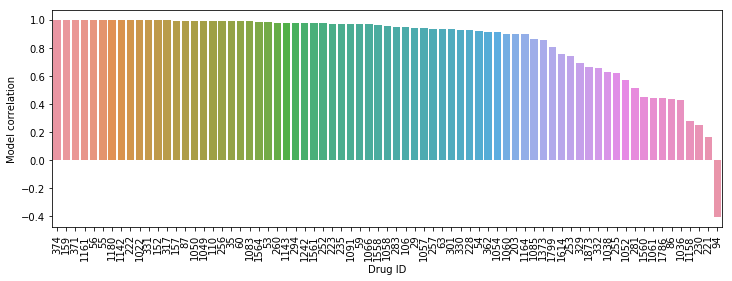

In [30]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

#### Evaluation on validation set

In [63]:
print(samples_val.shape)

(5866, 3)


In [64]:
# Predict on validation data and evaluate
sample = samples_val[:]
y_true = sample["AUC"].values

# Create baseline predictions(mean AUC)
mean_preds = np.array([mean_training_auc] * sample.shape[0])

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()

print("Model scores:")
print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.view(-1))

torch.Size([5866, 1]) tensor(2.3811) tensor(-4.0338) tensor(0.5972)
Baseline scores:
RMSE: 0.18352162371871672
Correlation: (nan, nan)

Model scores:
tensor(2.3811) tensor(-4.0338) tensor(0.5972)
RMSE: 0.5463192625697165
Correlation: (0.11624790267467003, 4.1911948227930274e-19)


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [65]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    dummy_preds = [mean_training_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(74, 6) 74
0.032948457949925736


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


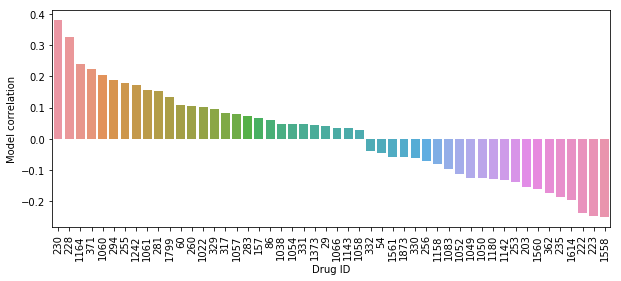

In [66]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

#### Evaluate on unseen cell lines

In [67]:
# Predict on unseen cell lines and evaluate
sample = samples_test
y_true = sample["AUC"].values

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.view(-1))

tensor(2.1030) tensor(-3.6626) tensor(0.5473)
RMSE: 0.5226993060739263
Correlation: (0.1527588729585517, 5.247973552308591e-31)


In [68]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    dummy_preds = [mean_training_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(74, 6) 74
0.05985532956288445


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


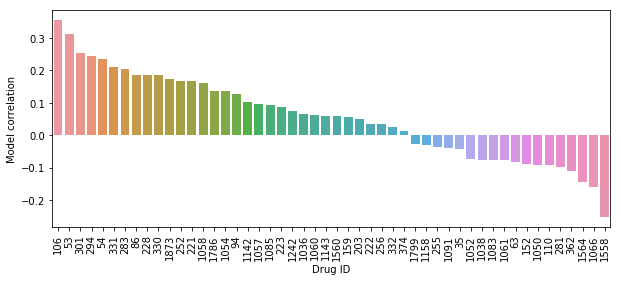

In [69]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

## Prototype Model class

In [39]:
class Model:
    def __init__(self, name, network):
        self.name = name
        self.network = network
        
    def train(self, train_samples, cell_line_features, drug_features,
             batch_size, optimizer, criterion, reg_lambda=0, log=True):
        """Perform training process by looping over training set in batches (one epoch) of the
        training."""
        no_batches = train_samples.shape[0] // batch_size + 1
        
        # Training the model
        self.network.train()
        for batch in range(no_batches):
            # Separate response variable batch
            if batch != no_batches:
                samples_batch = train_samples.iloc[batch * batch_size:(batch + 1) * batch_size]
            else:
                samples_batch = train_samples.iloc[batch * batch_size:]

            # Extract output variable batch
            y_batch = torch.from_numpy(samples_batch["AUC"].values).view(-1, 1)

            # Extract cell lines IDs for which data shall be extracted
            cl_ids = samples_batch["COSMIC_ID"].values
            # Extract corresponding cell line data
            cell_line_input_batch = cell_line_features.loc[cl_ids].values
            cell_line_input_batch = torch.from_numpy(cell_line_input_batch)

            # Extract drug IDs for which data shall be extracted
            drug_ids = samples_batch["DRUG_ID"].values
            # Extract corresponding drug data
            drug_input_batch = drug_features.loc[drug_ids].values
            drug_input_batch = torch.from_numpy(drug_input_batch)

            # Clear gradient buffers because we don't want to accummulate gradients 
            optimizer.zero_grad()

            # Perform forward pass
            batch_output = self.network(drug_input_batch.float(), cell_line_input_batch.float())

            reg_sum = 0
            for param in self.network.parameters():
                reg_sum += 0.5 * (param ** 2).sum()  # L2 norm

            # Compute the loss for this batch
            loss = criterion(batch_output, y_batch.float()) + reg_lambda * reg_sum
            # Get the gradients w.r.t. the parameters
            loss.backward()
            # Update the parameters
            optimizer.step()
        return loss
    
    def predict(self, samples, cell_line_features, drug_features):
        """Predict response on a given set of samples"""
        y_true = samples["AUC"].values

        cl_input = cell_line_features.loc[samples["COSMIC_ID"].values].values
        drug_input = drug_features.loc[samples["DRUG_ID"].values].values

        self.network.eval()
        with torch.no_grad():
            predicted = self.network(torch.from_numpy(drug_input).float(), 
                             torch.from_numpy(cl_input).float())
        return predicted, y_true
    
    @staticmethod
    def per_drug_performance_df(samples, predicted, mean_training_auc=None):
        """Compute evaluation metrics per drug and return them in a DataFrame"""
        sample_with_predictions = samples.copy()
        sample_with_predictions["Predicted AUC"] = predicted.numpy()

        drugs = []
        model_corrs = []
        model_rmses = []
        dummy_corrs = []
        dummy_rmses = []
        no_samples = []

        for drug in sample_with_predictions.DRUG_ID.unique():
            df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
            if df.shape[0] < 2:
                continue
            if mean_training_auc:
                dummy_preds = [mean_training_auc] * df.shape[0]
            else:
                dummy_preds = [df["AUC"].mean()] * df.shape[0]
            dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
            dummy_corr = pearsonr(df["AUC"], dummy_preds)

            model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
            model_corr = pearsonr(df["AUC"], df["Predicted AUC"])

            drugs.append(drug)
            dummy_rmses.append(dummy_rmse)
            dummy_corrs.append(dummy_corr[0])

            model_rmses.append(model_rmse)
            model_corrs.append(model_corr[0])

            no_samples.append(df.COSMIC_ID.nunique())

        performance_per_drug = pd.DataFrame()
        performance_per_drug["Drug ID"] = drugs
        performance_per_drug["Model RMSE"] = model_rmses
        performance_per_drug["Model correlation"] = model_corrs

        performance_per_drug["Dummy RMSE"] = dummy_rmses
        performance_per_drug["Dummy correlation"] = dummy_corrs
        performance_per_drug["No. samples"] = no_samples

        return performance_per_drug
        
    @staticmethod
    def evaluate_predictions(y_true, preds):
        """Compute RMSE and correlation with true values for model predictions"""
        return metrics.mean_squared_error(y_true, preds) ** 0.5, pearsonr(y_true, preds)

In [21]:
# Specify network shapes
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]
output_dim = 10

# Specify network
network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)
# Create Model instance
model_test = Model("Test model instance", network)

# Display text representation of model
model_test.network

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

In [22]:
# Do the training
# Specify learning parameters
batch_size = 32
learning_rate = 0.04
weight_decay = 0.
reg_lambda = 0.

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model_test.network.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loops
epochs = 30

for epoch in range(epochs):
    loss = model_test.train(samples_train, cell_line_data_df, drug_data_df, batch_size,
                    optimizer, criterion, reg_lambda=reg_lambda)
    
    print("Epoch {}, loss: {:.4f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 0.1112
Epoch 2, loss: 0.0311
Epoch 3, loss: 0.0239
Epoch 4, loss: 0.0215
Epoch 5, loss: 0.0197
Epoch 6, loss: 0.0178
Epoch 7, loss: 0.0161
Epoch 8, loss: 0.0146
Epoch 9, loss: 0.0132
Epoch 10, loss: 0.0119
Epoch 11, loss: 0.0108
Epoch 12, loss: 0.0099
Epoch 13, loss: 0.0091
Epoch 14, loss: 0.0084
Epoch 15, loss: 0.0078
Epoch 16, loss: 0.0073
Epoch 17, loss: 0.0068
Epoch 18, loss: 0.0065
Epoch 19, loss: 0.0062
Epoch 20, loss: 0.0059
Epoch 21, loss: 0.0057
Epoch 22, loss: 0.0055
Epoch 23, loss: 0.0053
Epoch 24, loss: 0.0052
Epoch 25, loss: 0.0051
Epoch 26, loss: 0.0050
Epoch 27, loss: 0.0049
Epoch 28, loss: 0.0048
Epoch 29, loss: 0.0048
Epoch 30, loss: 0.0047


In [23]:
mean_training_auc = samples_train["AUC"].mean()

In [25]:
predicted, y_true = model_test.predict(samples_train, cell_line_data_df, drug_data_df)
evaluate_predictions(y_true, predicted.reshape(-1))

RMSE: 0.09366216061173936
Correlation: (0.8635119503651711, 0.0)


In [27]:
df = Model.per_drug_performance_df(samples_train, predicted)
print(df.shape, df["Drug ID"].nunique())
print(df["Model correlation"].median())

(74, 6) 74
0.5844492661009474


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Prototype hyperparameter tuning with Tune library

In [40]:
print(samples_train.shape, samples_val.shape, samples_test.shape)

(1000, 3) (1000, 3) (1000, 3)


In [26]:
samples_train = samples_train.sample(1000, random_state=2)
samples_val = samples_val.sample(1000, random_state=2)
samples_test = samples_test.sample(1000, random_state=2)

In [41]:
print(samples_train["AUC"].sum(), samples_val["AUC"].sum(), samples_test["AUC"].sum())

819.8897959999999 836.261649 832.7825


In [79]:
import ray
from ray import tune
from ray.tune import track

In [80]:
# Specify network shapes
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]
output_dim = 10

# Specify network
network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)
# Create Model instance
model_test = Model("Test model instance", network)

# Learning parameters
criterion = torch.nn.MSELoss()

# Display text representation of model
model_test.network

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

In [81]:
model_test.network.drug_linear.weight.sum()

tensor(-0.7156, grad_fn=<SumBackward0>)

In [91]:
samples_train.shape

(1000, 3)

In [82]:
def trainable_for_tuning(config):
    optimizer = torch.optim.SGD(model_test.network.parameters(), lr=config["lr"])
    
    for epoch in range(1, epochs + 1):
        # Iterate over traning set
        loss = model_test.train(samples_train, cell_line_data_df, drug_data_df, config["batch_size"],
                     optimizer, criterion, reg_lambda=config["l2_lambda"])
        # Evaluate on training data
        predicted, y_true = model_test.predict(samples_train, cell_line_data_df, drug_data_df)
        train_rmse, train_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        performance_df = Model.per_drug_performance_df(samples_train, predicted)
        train_median_rmse = performance_df["Model RMSE"].median()
        train_median_corr = performance_df["Model correlation"].median()
        
        # Evaluate on validation data
        predicted, y_true = model_test.predict(samples_val, cell_line_data_df, drug_data_df)
        val_rmse, val_corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        performance_df = Model.per_drug_performance_df(samples_val, predicted)
        val_median_rmse = performance_df["Model RMSE"].median()
        val_median_corr = performance_df["Model correlation"].median()
        
        track.log(train_rmse=train_rmse, 
                  train_corr=train_corr[0], 
                  train_median_rmse = train_median_rmse, 
                  train_median_corr=train_median_corr,
                  val_rmse=val_rmse, 
                  val_corr=val_corr[0], 
                  val_median_rmse = val_median_rmse, 
                  val_median_corr=val_median_corr)

In [92]:
epochs = 50

# search_space = {
#     "lr": tune.choice([0.01, 0.1, 0.05]),
#     "batch_size": tune.choice([32, 64]),
#     "l2_lambda": tune.choice([0])
    
# }

search_space = {
    "lr": tune.loguniform(1e-3, 1e-1),
    "batch_size": tune.choice([16, 32, 64, 128, 256, 512, 1024]),
    "l2_lambda": tune.loguniform(1e-3, 1e-2)
    
}

ray.shutdown()
ray.init(num_cpus=1, num_gpus=0)



results_dir = "./Hyperparameter Tuning Tune Results"
analysis = tune.run(trainable_for_tuning, config=search_space, num_samples=10, local_dir=results_dir,
                   verbose=2)

2019-12-12 19:46:11,829	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-12 19:46:11,832	INFO resource_spec.py:205 -- Starting Ray with 1.71 GiB memory available for workers and up to 0.88 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-12-12 19:46:12,230	INFO function_runner.py:254 -- tune.track signature detected.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 3.6/7.5 GiB



2019-12-12 19:46:12,674	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 3.7/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Prototypes and baseline models/Hyperparameter Tuning Tune Results/trainable_for_tuning
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - trainable_for_tuning_1_batch_size=128,l2_lambda=0.0019346,lr=0.0055624:	PENDING
 - trainable_for_tuning_2_batch_size=16,l2_lambda=0.0041921,lr=0.046861:	PENDING
 - trainable_for_tuning_3_batch_size=64,l2_lambda=0.0037664,lr=0.0098397:	PENDING
 - trainable_for_tuning_4_batch_size=512,l2_lambda=0.001894,lr=0.0014022:	PENDING
 - trainable_for_tuning_5_batch_size=512,l2_lambda=0.0011573,lr=0.0024508:	PENDING
 - trainable_for_tuning_6_batch_size=32,l2_lambda=0.0018203,lr=0.0018555:	PENDING
 - trainable_for_tuning_7_batch_size=16,l2_lambda=0.0060755,lr=0.006

2019-12-12 19:46:31,685	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.
2019-12-12 19:46:32,169	WARNING worker.py:1619 -- The actor or task with ID ffffffffffffea33e12701000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {memory: 1.708984 GiB}, {object_store_memory: 0.585938 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster.


(pid=1650) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=1650)   warnings.warn(PearsonRConstantInputWarning())
Result for trainable_for_tuning_1_batch_size=128,l2_lambda=0.0019346,lr=0.0055624:
  date: 2019-12-12_19-46-33
  done: false
  experiment_id: df8d2b3d4b304048b9869fe174e96d62
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  node_ip: 192.168.0.78
  pid: 1650
  time_since_restore: 0.38634681701660156
  time_this_iter_s: 0.38634681701660156
  time_total_s: 0.38634681701660156
  timestamp: 1576176393
  timesteps_since_restore: 0
  train_corr: -0.015603126275782742
  train_median_corr: -0.0025653457157849627
  train_median_rmse: 0.42988813319567015
  train_rmse: 0.42350840316522304
  training_iteration: 0
  trial_id: ab5afa5a
  val_corr: -0.05499539095831603
  val_median_corr: -0.041850137385364396
  val_median_rmse: 0

Result for trainable_for_tuning_1_batch_size=128,l2_lambda=0.0019346,lr=0.0055624:
  date: 2019-12-12_19-46-55
  done: false
  experiment_id: df8d2b3d4b304048b9869fe174e96d62
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 49
  node_ip: 192.168.0.78
  pid: 1650
  time_since_restore: 21.678282499313354
  time_this_iter_s: 0.38790321350097656
  time_total_s: 21.678282499313354
  timestamp: 1576176415
  timesteps_since_restore: 0
  train_corr: 0.2423546790558574
  train_median_corr: 0.10709762615009262
  train_median_rmse: 0.35730059969953
  train_rmse: 0.34704770175077104
  training_iteration: 48
  trial_id: ab5afa5a
  val_corr: 0.020282029805130646
  val_median_corr: 0.05583004122029128
  val_median_rmse: 0.39349618277089826
  val_rmse: 0.4032238239096984
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 3.9/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Dokt

2019-12-12 19:46:55,664	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=3046) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=3046)   warnings.warn(PearsonRConstantInputWarning())
Result for trainable_for_tuning_2_batch_size=16,l2_lambda=0.0041921,lr=0.046861:
  date: 2019-12-12_19-46-58
  done: false
  experiment_id: 1efbe3098ca447ee86f328a88e63f087
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  node_ip: 192.168.0.78
  pid: 3046
  time_since_restore: 0.6390070915222168
  time_this_iter_s: 0.6390070915222168
  time_total_s: 0.6390070915222168
  timestamp: 1576176418
  timesteps_since_restore: 0
  train_corr: 0.2224660458284438
  train_median_corr: 0.1335550072788392
  train_median_rmse: 0.34884342906755456
  train_rmse: 0.3478941054836843
  training_iteration: 0
  trial_id: ab5fb4e6
  val_corr: 0.0492499633406852
  val_median_corr: 0.028349630109402946
  val_median_rmse: 0.400111514392182

Result for trainable_for_tuning_2_batch_size=16,l2_lambda=0.0041921,lr=0.046861:
  date: 2019-12-12_19-47-20
  done: false
  experiment_id: 1efbe3098ca447ee86f328a88e63f087
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 28
  node_ip: 192.168.0.78
  pid: 3046
  time_since_restore: 22.83766007423401
  time_this_iter_s: 1.1532509326934814
  time_total_s: 22.83766007423401
  timestamp: 1576176440
  timesteps_since_restore: 0
  train_corr: 0.9680231627370092
  train_median_corr: 0.8970509688399766
  train_median_rmse: 0.050412610226114415
  train_rmse: 0.055436825127779046
  training_iteration: 27
  trial_id: ab5fb4e6
  val_corr: 0.21366765199503732
  val_median_corr: 0.055902222066221835
  val_median_rmse: 0.2825018710978491
  val_rmse: 0.34592720281756334
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Dokto

2019-12-12 19:47:39,563	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=3417) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=3417)   warnings.warn(PearsonRConstantInputWarning())
Result for trainable_for_tuning_3_batch_size=64,l2_lambda=0.0037664,lr=0.0098397:
  date: 2019-12-12_19-47-42
  done: false
  experiment_id: 9538495339d04228ae196a1b6a2207f0
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  node_ip: 192.168.0.78
  pid: 3417
  time_since_restore: 0.5929138660430908
  time_this_iter_s: 0.5929138660430908
  time_total_s: 0.5929138660430908
  timestamp: 1576176462
  timesteps_since_restore: 0
  train_corr: -0.0005867321741352088
  train_median_corr: -0.006108680885224288
  train_median_rmse: 0.4205162183717307
  train_rmse: 0.4133725641943452
  training_iteration: 0
  trial_id: ab61d514
  val_corr: -0.050728213317232304
  val_median_corr: -0.04009822858866117
  val_median_rmse: 0.41377

Result for trainable_for_tuning_3_batch_size=64,l2_lambda=0.0037664,lr=0.0098397:
  date: 2019-12-12_19-48-03
  done: false
  experiment_id: 9538495339d04228ae196a1b6a2207f0
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 41
  node_ip: 192.168.0.78
  pid: 3417
  time_since_restore: 21.97669219970703
  time_this_iter_s: 0.49387168884277344
  time_total_s: 21.97669219970703
  timestamp: 1576176483
  timesteps_since_restore: 0
  train_corr: 0.5040648991310493
  train_median_corr: 0.2828269423020422
  train_median_rmse: 0.2734422582725751
  train_rmse: 0.27669987970572746
  training_iteration: 40
  trial_id: ab61d514
  val_corr: 0.08175179801002698
  val_median_corr: 0.1090251085724965
  val_median_rmse: 0.3815889214812381
  val_rmse: 0.403276618091725
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat -

2019-12-12 19:48:08,054	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=5239) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=5239)   warnings.warn(PearsonRConstantInputWarning())
Result for trainable_for_tuning_4_batch_size=512,l2_lambda=0.001894,lr=0.0014022:
  date: 2019-12-12_19-48-10
  done: false
  experiment_id: d515b8d6b358461cb1ce845066438759
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  node_ip: 192.168.0.78
  pid: 5239
  time_since_restore: 0.431107759475708
  time_this_iter_s: 0.431107759475708
  time_total_s: 0.431107759475708
  timestamp: 1576176490
  timesteps_since_restore: 0
  train_corr: -0.020579205747505998
  train_median_corr: -0.01406437157625022
  train_median_rmse: 0.4346773155953268
  train_rmse: 0.42819529249587
  training_iteration: 0
  trial_id: ab63da9e
  val_corr: -0.05566298289695844
  val_median_corr: -0.03258917700854685
  val_median_rmse: 0.4239915155360

2019-12-12 19:48:30,196	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=5662) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=5662)   warnings.warn(PearsonRConstantInputWarning())
Result for trainable_for_tuning_5_batch_size=512,l2_lambda=0.0011573,lr=0.0024508:
  date: 2019-12-12_19-48-32
  done: false
  experiment_id: 9ca174cbd9654fc0905a87f06b1e992d
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  node_ip: 192.168.0.78
  pid: 5662
  time_since_restore: 0.446821928024292
  time_this_iter_s: 0.446821928024292
  time_total_s: 0.446821928024292
  timestamp: 1576176512
  timesteps_since_restore: 0
  train_corr: -0.02033817951919477
  train_median_corr: -0.01343585723997772
  train_median_rmse: 0.43443247289332404
  train_rmse: 0.42794881443690125
  training_iteration: 0
  trial_id: ab65f5fe
  val_corr: -0.0556449529796211
  val_median_corr: -0.03303856738071954
  val_median_rmse: 0.4237755594

2019-12-12 19:48:50,941	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=6091) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=6091)   warnings.warn(PearsonRConstantInputWarning())
Result for trainable_for_tuning_6_batch_size=32,l2_lambda=0.0018203,lr=0.0018555:
  date: 2019-12-12_19-48-53
  done: false
  experiment_id: e332ff5555d041c2b0db2b09b894bf28
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  node_ip: 192.168.0.78
  pid: 6091
  time_since_restore: 0.4795799255371094
  time_this_iter_s: 0.4795799255371094
  time_total_s: 0.4795799255371094
  timestamp: 1576176533
  timesteps_since_restore: 0
  train_corr: -0.013521999219285248
  train_median_corr: -0.014975719393859784
  train_median_rmse: 0.42664711458638743
  train_rmse: 0.42210025426837433
  training_iteration: 0
  trial_id: ab67d7de
  val_corr: -0.05488335600608461
  val_median_corr: -0.046723740405246135
  val_median_rmse: 0.4210

Result for trainable_for_tuning_6_batch_size=32,l2_lambda=0.0018203,lr=0.0018555:
  date: 2019-12-12_19-49-14
  done: false
  experiment_id: e332ff5555d041c2b0db2b09b894bf28
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 41
  node_ip: 192.168.0.78
  pid: 6091
  time_since_restore: 22.024895668029785
  time_this_iter_s: 0.5708937644958496
  time_total_s: 22.024895668029785
  timestamp: 1576176554
  timesteps_since_restore: 0
  train_corr: 0.2614646467738495
  train_median_corr: 0.12994417864300495
  train_median_rmse: 0.3524812477628727
  train_rmse: 0.3426572013309869
  training_iteration: 40
  trial_id: ab67d7de
  val_corr: 0.022445306331080737
  val_median_corr: 0.05068350880294176
  val_median_rmse: 0.3872394761527016
  val_rmse: 0.40375071178642574
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 3.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Dokto

2019-12-12 19:49:19,739	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


Result for trainable_for_tuning_6_batch_size=32,l2_lambda=0.0018203,lr=0.0018555:
  date: 2019-12-12_19-49-19
  done: false
  experiment_id: e332ff5555d041c2b0db2b09b894bf28
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 50
  node_ip: 192.168.0.78
  pid: 6091
  time_since_restore: 27.184224605560303
  time_this_iter_s: 0.5320713520050049
  time_total_s: 27.184224605560303
  timestamp: 1576176559
  timesteps_since_restore: 0
  train_corr: 0.3061408262544506
  train_median_corr: 0.15793982210256957
  train_median_rmse: 0.3416568006543476
  train_rmse: 0.33239123864802245
  training_iteration: 49
  trial_id: ab67d7de
  val_corr: 0.033051683854026105
  val_median_corr: 0.0598280419315892
  val_median_rmse: 0.3859145359790128
  val_rmse: 0.4034345465602263
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 3.4/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktor

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Prototypes and baseline models/Hyperparameter Tuning Tune Results/trainable_for_tuning
Number of trials: 10 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - trainable_for_tuning_8_batch_size=128,l2_lambda=0.0012807,lr=0.01074:	PENDING
 - trainable_for_tuning_9_batch_size=128,l2_lambda=0.0014826,lr=0.075046:	PENDING
RUNNING trials:
 - trainable_for_tuning_7_batch_size=16,l2_lambda=0.0060755,lr=0.0061224:	RUNNING, [1 CPUs, 0 GPUs], [pid=6315], 13 s, 20 iter
TERMINATED trials:
 - trainable_for_tuning_0_batch_size=1024,l2_lambda=0.0032377,lr=0.051819:	TERMINATED, [1 CPUs, 0 GPUs], [pid=1155], 17 s, 49 iter
 - trainable_for_tuning_1_batch_size=128,l2_lambda=0.0019346,lr=0.0055624:	TERMINATED, [

2019-12-12 19:49:53,498	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=6582) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=6582)   warnings.warn(PearsonRConstantInputWarning())
Result for trainable_for_tuning_8_batch_size=128,l2_lambda=0.0012807,lr=0.01074:
  date: 2019-12-12_19-49-55
  done: false
  experiment_id: 4e1dfd27f80e44339558d12b7ba8187e
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  node_ip: 192.168.0.78
  pid: 6582
  time_since_restore: 0.5119884014129639
  time_this_iter_s: 0.5119884014129639
  time_total_s: 0.5119884014129639
  timestamp: 1576176595
  timesteps_since_restore: 0
  train_corr: -0.010420258924590536
  train_median_corr: -0.010525388310393905
  train_median_rmse: 0.425408768619866
  train_rmse: 0.41934119084362553
  training_iteration: 0
  trial_id: ab6bedd8
  val_corr: -0.05396064640833655
  val_median_corr: -0.04737861322576298
  val_median_rmse: 0.42015608

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Prototypes and baseline models/Hyperparameter Tuning Tune Results/trainable_for_tuning
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - trainable_for_tuning_9_batch_size=128,l2_lambda=0.0014826,lr=0.075046:	PENDING
RUNNING trials:
 - trainable_for_tuning_8_batch_size=128,l2_lambda=0.0012807,lr=0.01074:	RUNNING, [1 CPUs, 0 GPUs], [pid=6582], 16 s, 39 iter
TERMINATED trials:
 - trainable_for_tuning_0_batch_size=1024,l2_lambda=0.0032377,lr=0.051819:	TERMINATED, [1 CPUs, 0 GPUs], [pid=1155], 17 s, 49 iter
 - trainable_for_tuning_1_batch_size=128,l2_lambda=0.0019346,lr=0.0055624:	TERMINATED, [1 CPUs, 0 GPUs], [pid=1650], 22 s, 49 iter
 - trainable_for_tuning_2_batch_size=16

2019-12-12 19:50:16,020	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


(pid=7662) /home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
(pid=7662)   warnings.warn(PearsonRConstantInputWarning())
Result for trainable_for_tuning_9_batch_size=128,l2_lambda=0.0014826,lr=0.075046:
  date: 2019-12-12_19-50-18
  done: false
  experiment_id: 1e5d55abd10f43a89e013821df65de04
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  node_ip: 192.168.0.78
  pid: 7662
  time_since_restore: 0.41782283782958984
  time_this_iter_s: 0.41782283782958984
  time_total_s: 0.41782283782958984
  timestamp: 1576176618
  timesteps_since_restore: 0
  train_corr: 0.05805745455580639
  train_median_corr: -0.014647402491297076
  train_median_rmse: 0.39735753387247696
  train_rmse: 0.3899655953211199
  training_iteration: 0
  trial_id: ab6e32aa
  val_corr: -0.02635746425659004
  val_median_corr: -0.015430297919748722
  val_median_rmse: 0.4007

2019-12-12 19:50:35,558	INFO tune.py:276 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/1 CPUs, 0/0 GPUs, 0.0/1.71 GiB heap, 0.0/0.59 GiB objects
Memory usage on this node: 3.3/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Prototypes and baseline models/Hyperparameter Tuning Tune Results/trainable_for_tuning
Number of trials: 10 ({'TERMINATED': 10})
TERMINATED trials:
 - trainable_for_tuning_0_batch_size=1024,l2_lambda=0.0032377,lr=0.051819:	TERMINATED, [1 CPUs, 0 GPUs], [pid=1155], 17 s, 49 iter
 - trainable_for_tuning_1_batch_size=128,l2_lambda=0.0019346,lr=0.0055624:	TERMINATED, [1 CPUs, 0 GPUs], [pid=1650], 22 s, 49 iter
 - trainable_for_tuning_2_batch_size=16,l2_lambda=0.0041921,lr=0.046861:	TERMINATED, [1 CPUs, 0 GPUs], [pid=3046], 42 s, 49 iter
 - trainable_for_tuning_3_batch_size=64,l2_lambda=0.0037664,lr=0.0098397:	TERMINATED, [1 CPUs, 0 GPUs], [pid=3417], 26 s, 49 iter
 - trainable_for_tuning_4_batch_size=512,l2_lam

In [85]:
# ! rm -r "./Hyperparameter Tuning Tune Results"

In [93]:
model_test.network.drug_linear.weight.sum()

tensor(-0.7156, grad_fn=<SumBackward0>)

In [94]:
full_df = analysis.dataframe()
print(full_df.shape)
metrics = ["train_rmse", "train_corr", "train_median_rmse", "train_median_corr",
          "val_rmse", "val_corr"]
cols = ["pid"] + [x for x in full_df if x.startswith("config")] + ["training_iteration"]

full_df[cols + metrics]

(10, 28)


,pid,config/batch_size,config/l2_lambda,config/lr,training_iteration,train_rmse,train_corr,train_median_rmse,train_median_corr,val_rmse,val_corr
0,1155,1024,0.003238,0.051819,49,0.338480,0.282127,0.348870,0.167153,0.402562,0.028432
1,1650,128,0.001935,0.005562,49,0.346106,0.246663,0.356476,0.109201,0.403154,0.021334
2,3046,16,0.004192,0.046861,49,0.045538,0.981158,0.042623,0.950010,0.330984,0.242036
3,3417,64,0.003766,0.009840,49,0.257384,0.555209,0.249676,0.299856,0.403565,0.091488
4,5239,512,0.001894,0.001402,49,0.414719,-0.003424,0.423916,-0.000694,0.420137,-0.052645
5,5662,512,0.001157,0.002451,49,0.407327,0.010792,0.413546,-0.008192,0.416578,-0.048403
6,6091,32,0.001820,0.001856,49,0.332391,0.306141,0.341657,0.157940,0.403435,0.033052
7,6315,16,0.006076,0.006122,49,0.147231,0.800074,0.135039,0.526834,0.397837,0.115376
8,6582,128,0.001281,0.010740,49,0.308672,0.400625,0.314978,0.215801,0.402611,0.058473
9,7662,128,0.001483,0.075046,49,0.098267,0.891922,0.086090,0.688749,0.398433,0.125205


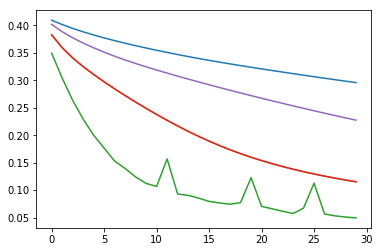

In [50]:
dfs = analysis.trial_dataframes
[d.train_rmse.plot() for d in dfs.values()]
plt.show()

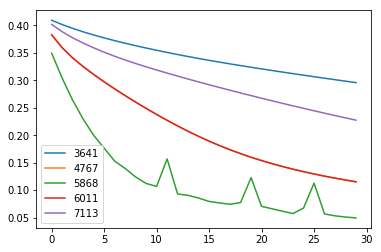

In [51]:
dfs = analysis.trial_dataframes
s = 0
for d in dfs.values():
    plt.plot(d["training_iteration"], d["train_rmse"], label=d["pid"].iloc[0])
    s += 1

plt.legend()
plt.show()

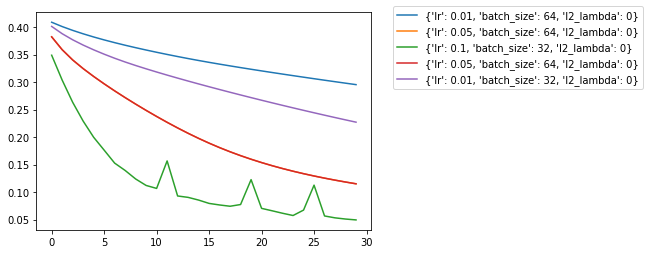

In [61]:
metric = "train_rmse"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    plt.plot(df["training_iteration"], df[metric], label=str(trial.config))

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

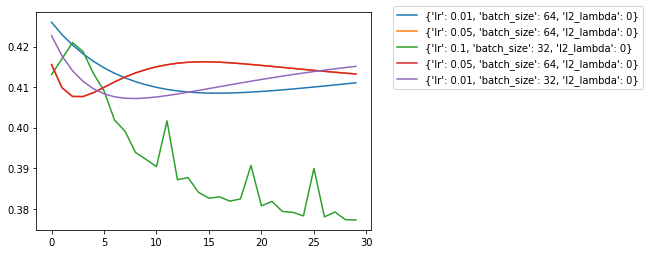

In [62]:
metric = "val_rmse"
for trial in analysis.trials:
    df = analysis.trial_dataframes[trial.logdir]
    plt.plot(df["training_iteration"], df[metric], label=str(trial.config))

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

In [66]:
analysis.trials[0].__dir__()

['trainable_name',
 'trial_id',
 'config',
 'local_dir',
 'evaluated_params',
 'experiment_tag',
 'resources',
 'stopping_criterion',
 'loggers',
 'sync_to_driver_fn',
 'verbose',
 'max_failures',
 'last_result',
 'last_update_time',
 'checkpoint_freq',
 'checkpoint_at_end',
 'history',
 'keep_checkpoints_num',
 '_cmp_greater',
 'best_checkpoint_attr_value',
 'checkpoint_score_attr',
 '_checkpoint',
 'export_formats',
 'status',
 'logdir',
 'runner',
 'result_logger',
 'last_debug',
 'error_file',
 'error_msg',
 'num_failures',
 'custom_trial_name',
 'results',
 'best_result',
 'param_config',
 'extra_arg',
 '_nonjson_fields',
 '__module__',
 '__doc__',
 'PENDING',
 'RUNNING',
 'PAUSED',
 'TERMINATED',
 'ERROR',
 '__init__',
 '_registration_check',
 'generate_id',
 'create_logdir',
 'init_logger',
 'update_resources',
 'sync_logger_to_new_location',
 'close_logger',
 'write_error_log',
 'should_stop',
 'should_checkpoint',
 'progress_string',
 '_status_string',
 'has_checkpoint',
 'cle

In [68]:
analysis.trials[0].trial_id

'0a1c4f78'